In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import pickle as pkl
import os
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set(style='whitegrid')
device = torch.device("cuda")

In [209]:
def sample_batch_singindex(B, d_in, device="cuda"):
    x = torch.randn(B, d_in, device=device) / math.sqrt(d_in)
    y = f_hermite(x @ teacher_weights).reshape(-1, 1)
    return x, y

def train_model(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda", type="mup"):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        for lr in lrs:
            has_nan = False
            model = MLP2Hidden(d_in, width, 1).to(device)
            if type == "mup":
                model.init_weights_mup()
                optimizer = model.init_optimizer_mup(lr, optimizer="Adam")
            elif type == "ntk":
                model.init_weights_ntk()
                optimizer = model.init_optimizer_ntk(lr)
            else:
                raise ValueError("Invalid type")
            model.train()
            for step in range(T):
                if has_nan:
                    train_losses[width][lr].append(np.nan)
                    continue
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
                if torch.isnan(loss):
                    has_nan = True
                if step % 2000 == 0 and step > 100:
                    print(f"Step {step} for width {width}, lr {lr}, Loss: {np.mean(train_losses[width][lr][-1000:])}")
            if has_nan:
                print(f"Model {width} with lr {lr} has NaN loss")
    return train_losses

In [230]:
d_in = 8
def f_hermite(x): return (x**5 - 10*x**3 + 15*x)/math.sqrt(120)
torch.manual_seed(32)
teacher_weights = torch.randn(d_in, 1, device=device)
teacher_weights /= teacher_weights.norm()
teacher_weights *= math.sqrt(d_in)

Step 2000 for width 512, lr 0.01, Loss: 0.7106297467947006
Step 4000 for width 512, lr 0.01, Loss: 0.5835393970981241
Step 6000 for width 512, lr 0.01, Loss: 0.5238970641046763
Step 8000 for width 512, lr 0.01, Loss: 0.41528843604773286
Step 10000 for width 512, lr 0.01, Loss: 0.3479832983165979
Step 12000 for width 512, lr 0.01, Loss: 0.26012577027641237
Step 14000 for width 512, lr 0.01, Loss: 0.32093996477499603
Step 16000 for width 512, lr 0.01, Loss: 0.2508115959335119
Step 18000 for width 512, lr 0.01, Loss: 0.2014651181390509
Step 20000 for width 512, lr 0.01, Loss: 0.14651672655995934
Step 22000 for width 512, lr 0.01, Loss: 0.18304917566291987
Step 24000 for width 512, lr 0.01, Loss: 0.11613060152949765
Step 26000 for width 512, lr 0.01, Loss: 0.13695098326401786
Step 28000 for width 512, lr 0.01, Loss: 0.11660963811678812
Step 30000 for width 512, lr 0.01, Loss: 0.10533818641537801
Step 32000 for width 512, lr 0.01, Loss: 0.11106029980210587
Step 34000 for width 512, lr 0.01,

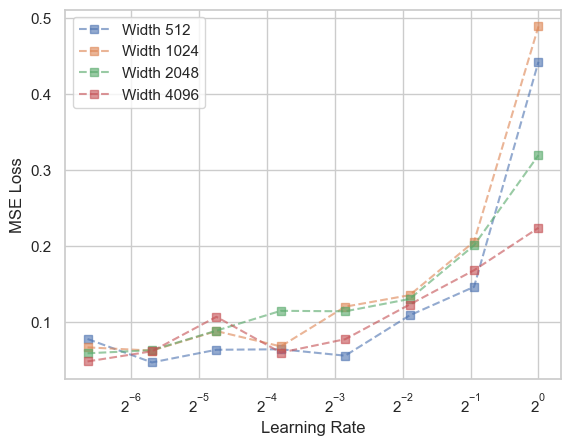

In [242]:
widths = [512, 1024, 2048, 4096]
lrs = np.logspace(-2.0, 0.0, 8)
B = 2048
T = 50001
type = "mup"
train_losses_mup = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][-3000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()

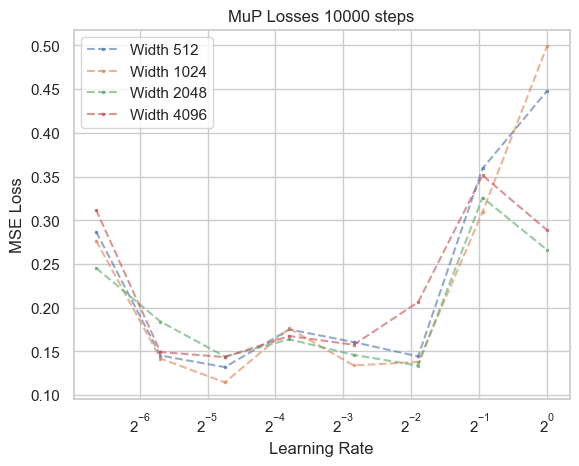

In [257]:
lrs = np.logspace(-2.0, 0.0, 8)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][-40000:-35000]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=2, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.title("MuP Losses 10000 steps")
plt.legend()

Step 2000 for width 4096, lr 0.03162277660168379, Loss: 1.0423558879494668
Step 4000 for width 4096, lr 0.03162277660168379, Loss: 0.9732564894258976
Step 6000 for width 4096, lr 0.03162277660168379, Loss: 0.9474808940291405
Step 8000 for width 4096, lr 0.03162277660168379, Loss: 0.9562266727089882
Step 10000 for width 4096, lr 0.03162277660168379, Loss: 0.9922403925359249
Step 12000 for width 4096, lr 0.03162277660168379, Loss: 0.9718866340517998
Step 14000 for width 4096, lr 0.03162277660168379, Loss: 0.8895862985253334
Step 16000 for width 4096, lr 0.03162277660168379, Loss: 0.9583551735281944
Step 18000 for width 4096, lr 0.03162277660168379, Loss: 0.9361808857917786
Step 20000 for width 4096, lr 0.03162277660168379, Loss: 0.8761366299986839
Step 22000 for width 4096, lr 0.03162277660168379, Loss: 0.9227920503020287
Step 24000 for width 4096, lr 0.03162277660168379, Loss: 0.9332217526137829
Step 26000 for width 4096, lr 0.03162277660168379, Loss: 0.8574200213104487
Step 28000 for w

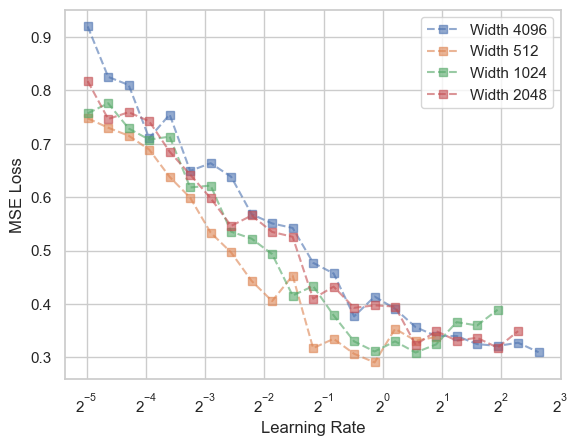

In [232]:
widths = [4096, 512, 1024, 2048, ]
lrs = np.logspace(-1.5, 1.0, 25)
B = 2048
T = 50001
type = "ntk"
train_losses_ntk_3 = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_ntk_3[width][lr][-3000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()

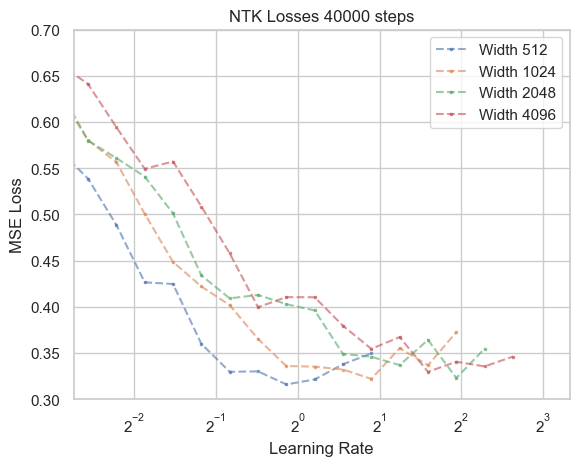

In [258]:
lrs = np.logspace(-1.5, 1.0, 25)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_ntk_3[width][lr][40000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=2, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.xlim(0.15, 10.00)
plt.ylim(0.3, 0.7)
plt.title("NTK Losses 40000 steps")
plt.legend()

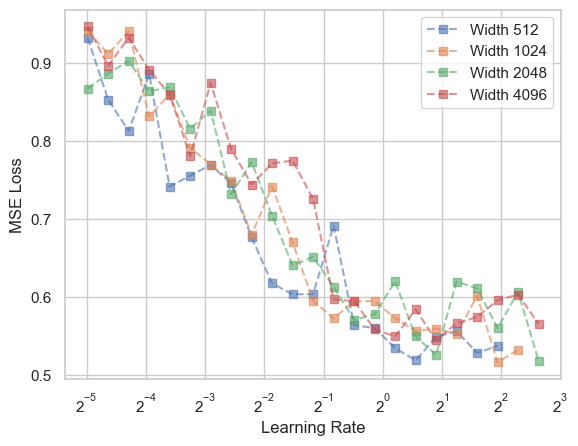

In [259]:
lrs = np.logspace(-1.5, 1.0, 25)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_ntk_3[width][lr][12000:14000]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()